In [86]:
import os
import sys
import time
sys.path.append('..')
import pystan
from datetime import datetime
from fbprophet import Prophet
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.support_function import str_to_datetime, eval_metrics, timestamp_hour

## 准备数据集

In [3]:
root_1 = '../Dataset'
df_ma = pd.read_csv(os.path.join(root_1, '15流量_dataset_washed.csv'))
df_ma.head(3)

,datetime,552叶汤路Q,625 港区大道Q,637 新338省道Q,666 常戚路Q,727 玉龙路Q,785 长江路龙城大道Q,794 龙江路Q,800 健身路Q
0,2017-01-01 00:00:00,0.191011,0.333333,0.086294,0.184466,0.119617,0.117949,0.098093,0.109375
1,2017-01-01 00:15:00,0.191011,0.333333,0.086294,0.184466,0.119617,0.117949,0.098093,0.109375
2,2017-01-01 00:30:00,0.172285,0.380952,0.076142,0.155340,0.110048,0.110256,0.100817,0.109375


In [24]:
aim_column = '637 新338省道Q'
df = df_ma[['datetime', aim_column]]
df = df.rename(columns={'datetime':'ds', aim_column:'y'})
df.shape

(92736, 2)

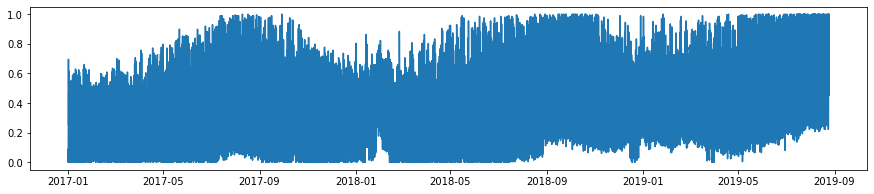

In [13]:
df_plot = df.copy()
df_plot['ds'] = df_plot['ds'].apply(str_to_datetime)
plt.figure(figsize=(15,3))
plt.plot(df_plot['ds'], df_plot['y'])

In [44]:
start_point = 0
# train_size = int(df.shape[0] * 0.6)
train_size = 10000
test_size = 4*24
df_train = df.iloc[start_point: start_point+train_size]
df_test = df.iloc[start_point+train_size: start_point+train_size+test_size]

## 画出训练集和测试集

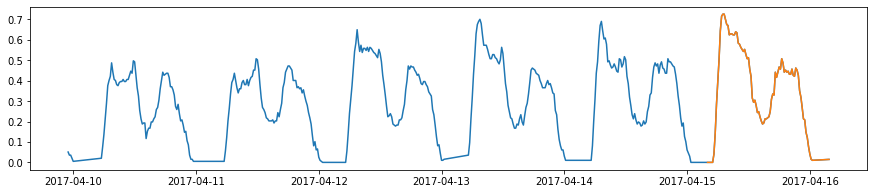

In [46]:
df_train_test = df.iloc[start_point: start_point+train_size+test_size]
df_train_test.loc[:, 'ds'] = df_train_test.loc[:, 'ds'].copy().apply(str_to_datetime)
df_train_test = df_train_test.set_index('ds')
plt.figure(figsize=(15,3))
plt.plot(df_train_test['y'].tail(500+test_size))
plt.plot(df_train_test['y'].iloc[-test_size:])
plt.show()

## Fbprophet 预测

In [94]:
m = Prophet(
    n_changepoints=100
)

In [95]:
since = time.time()
m.fit(df_train)
print('fit in', time.time()-since)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


fit in 56.073076009750366


In [57]:
future = m.make_future_dataframe(periods=test_size, freq='15min')
forecast = m.predict(future)

In [56]:
print(eval_metrics(df_test['y'].values, forecast['yhat'].tail(test_size).values))

..\src\support_function.py:23: RuntimeWarning: divide by zero encountered in true_divide
  metrics_dict['MAPE'] = np.mean(np.true_divide(np.abs(y_true-y_pred), y_true))


{'MAE': 0.0729299195652241, 'MSE': 0.01336016882587767, 'MAPE': inf}


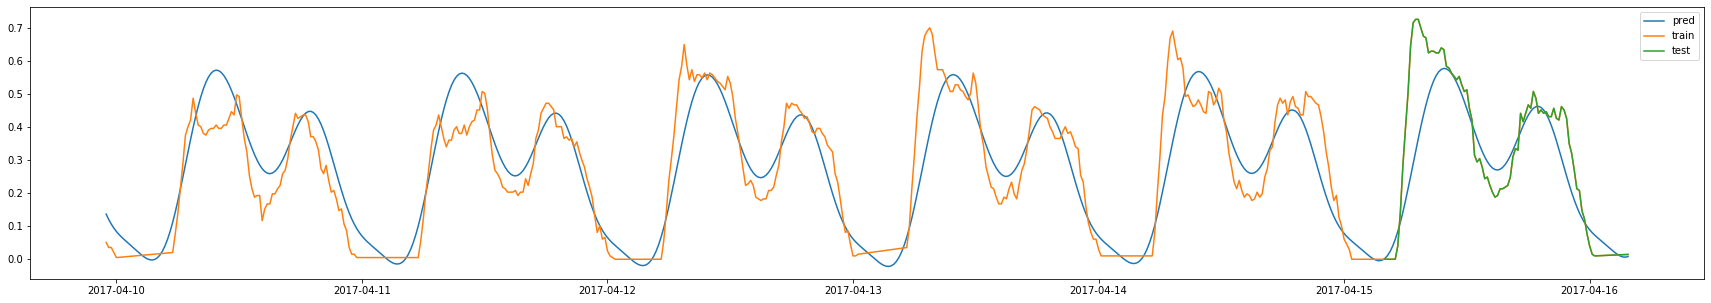

In [50]:
plt.figure(figsize=(30, 5), facecolor='w')
plt.plot(forecast['ds'].tail(500+test_size), forecast['yhat'].tail(500+test_size))
plt.plot(df_train_test['y'].tail(500+test_size))
plt.plot(df_train_test['y'].iloc[-test_size:])
plt.legend(['pred', 'train', 'test'])
plt.show()

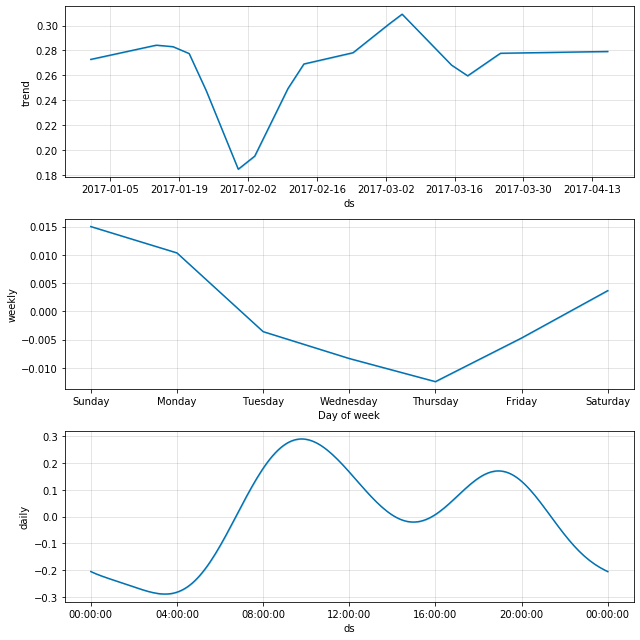

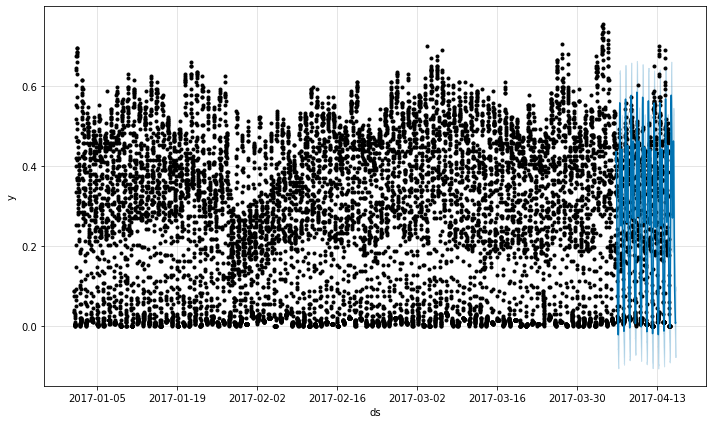

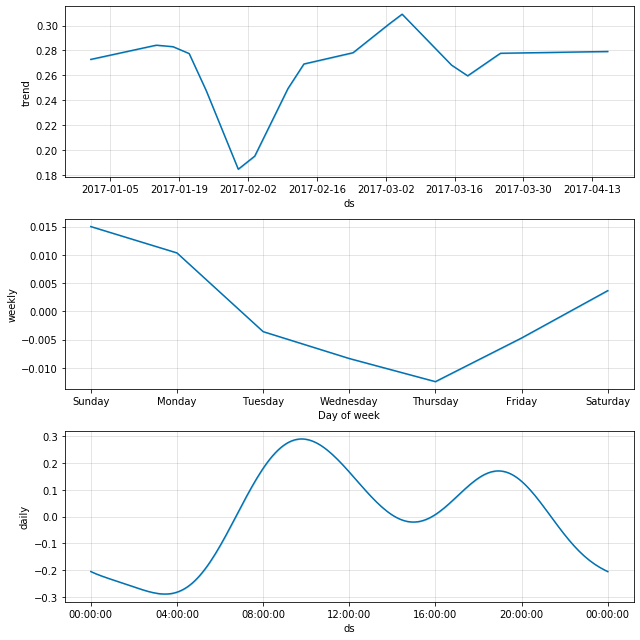

In [100]:
m.plot(forecast.tail(1000))
m.plot_components(forecast)

In [59]:
df.head(10)

,ds,y
0,2017-01-01 00:00:00,0.086294
1,2017-01-01 00:15:00,0.086294
2,2017-01-01 00:30:00,0.076142
3,2017-01-01 00:45:00,0.040609
4,2017-01-01 01:00:00,0.035533
5,2017-01-01 01:15:00,0.035533
6,2017-01-01 01:30:00,0.025381
7,2017-01-01 01:45:00,0.010152
8,2017-01-01 02:00:00,0.005076
9,2017-01-01 02:15:00,0.020305


In [88]:
def datetime_minute(x):
    return x.minute
df_plot['minute'] = df_plot['ds'].apply(datetime_minute)
df_plot['hour'] = df_plot['ds'].apply(timestamp_hour)
df_plot['hour_min'] = df_plot['hour']*60 + df_plot['minute']

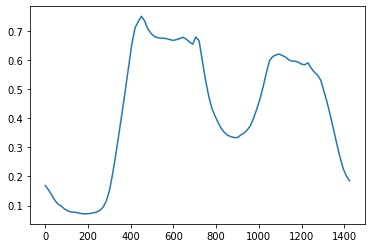

In [93]:
day_mean = df_plot.groupby('hour_min').mean()
plt.plot(day_mean['y'])
plt.show()

## 季节性趋势

In [106]:
df_season = df_ma[['datetime', '552叶汤路Q']]
df_season = df_season.rename(columns={'datetime':'ds', '552叶汤路Q':'y'})

In [107]:
rolling_num = 3 * 24 * 4
df_season['y'] = df_season['y'].rolling(rolling_num).mean()
df_season = df_season.iloc[rolling_num:]
df_season.loc[:, 'ds'] = df_season.loc[:, 'ds'].copy().apply(str_to_datetime)

In [108]:
df_season.head(3)

,ds,y
288,2017-01-04 00:00:00,0.373439
289,2017-01-04 00:15:00,0.373296
290,2017-01-04 00:30:00,0.373153


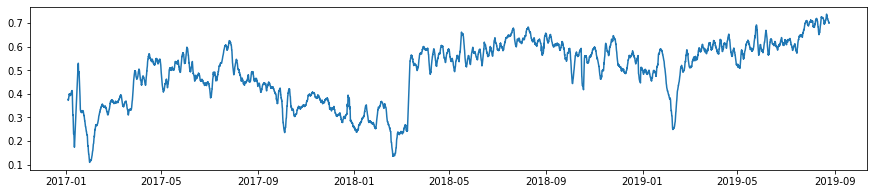

In [109]:
plt.figure(figsize=(15,3))
plt.plot(df_season['ds'], df_season['y'])
plt.show()